<a href="https://colab.research.google.com/github/edemana/EDEMANAGBAH._SportsPrediction/blob/main/EDEMANAGBAH__SportsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### Data Preparation & Feature Extraction


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import pickle as pkl

In [6]:
def clean_data(df, useless_columns):
    # Drop useless columns
    useless_columns_in_df = [col for col in useless_columns if col in df.columns]
    df.drop(columns=useless_columns_in_df, inplace=True)

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Encode categorical variables
    categorical_features = df_imputed.select_dtypes(include=['object']).columns
    label_encoders = {}

    for col in categorical_features:
        le = LabelEncoder()
        df_imputed[col] = le.fit_transform(df_imputed[col])
        label_encoders[col] = le

    # Select numerical features BEFORE scaling
    numerical_features = df_imputed.select_dtypes(include=[np.number]).columns

    # Scale numerical features
    scaler = StandardScaler()
    df_imputed[numerical_features] = scaler.fit_transform(df_imputed[numerical_features])

    return df_imputed, label_encoders


In [7]:
male_legacy_path = '/content/drive/My Drive/Colab Notebooks/male_players (legacy).csv'
players_22_path = '/content/drive/My Drive/Colab Notebooks/players_22-1.csv'

# Load datasets
male_legacy = pd.read_csv(male_legacy_path, low_memory=False)
players_22 = pd.read_csv(players_22_path, low_memory=False)


# List of columns to drop
useless_columns = [
    'player_id', 'player_url', 'fifa_version', 'fifa_update_date', 'player_face_url',
    'fifa_update', 'dob', 'short_name', 'long_name', 'league_id', 'league_name',
    'club_team_id', 'club_name', 'club_jersey_number', 'club_loaned_from',
    'club_joined_date', 'club_contract_valid_until_year', 'nationality_id',
    'nationality_name', 'nation_team_id', 'nation_jersey_number', 'real_face',
    'body_type', 'release_clause_eur', 'player_tags', 'player_traits',
    'mentality_composure', 'work_rate',
    'player_positions', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
    'league_level', 'club_position', 'nation_position', 'preferred_foot',
    'goalkeeping_speed', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam',
    'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm',
    'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk','club_logo_url','club_flag_url',
    'nation_logo_url','nation_flag_url','club_joined','sofifa_id', 'goalkeeping_diving',
    'goalkeeping_handling', 'goalkeeping_positioning', 'goalkeeping_reflexes',
    'goalkeeping_kicking'
]

# Clean data
male_legacy_cleaned, male_legacy_encoders = clean_data(male_legacy, useless_columns)

# Save the feature names after cleaning
#training_features = male_legacy_cleaned.columns.tolist()



### Feature Selection

In [8]:
def norm_feat_names(features):
    return [feature.lower().replace('_', '') for feature in features]

def align_features(test_df, training_df):
    test_df.columns = norm_feat_names(test_df.columns)
    training_df.columns = norm_feat_names(training_df.columns )
    # Ensure the test dataframe has the same columns as the training dataframe
    missing_cols = [col for col in training_df.columns  if col not in test_df.columns]
    for col in missing_cols:
        test_df[col] = 0
    # Reorder columns to match the training dataframe
    test_df = test_df[training_df.columns ]
    return test_df, training_df


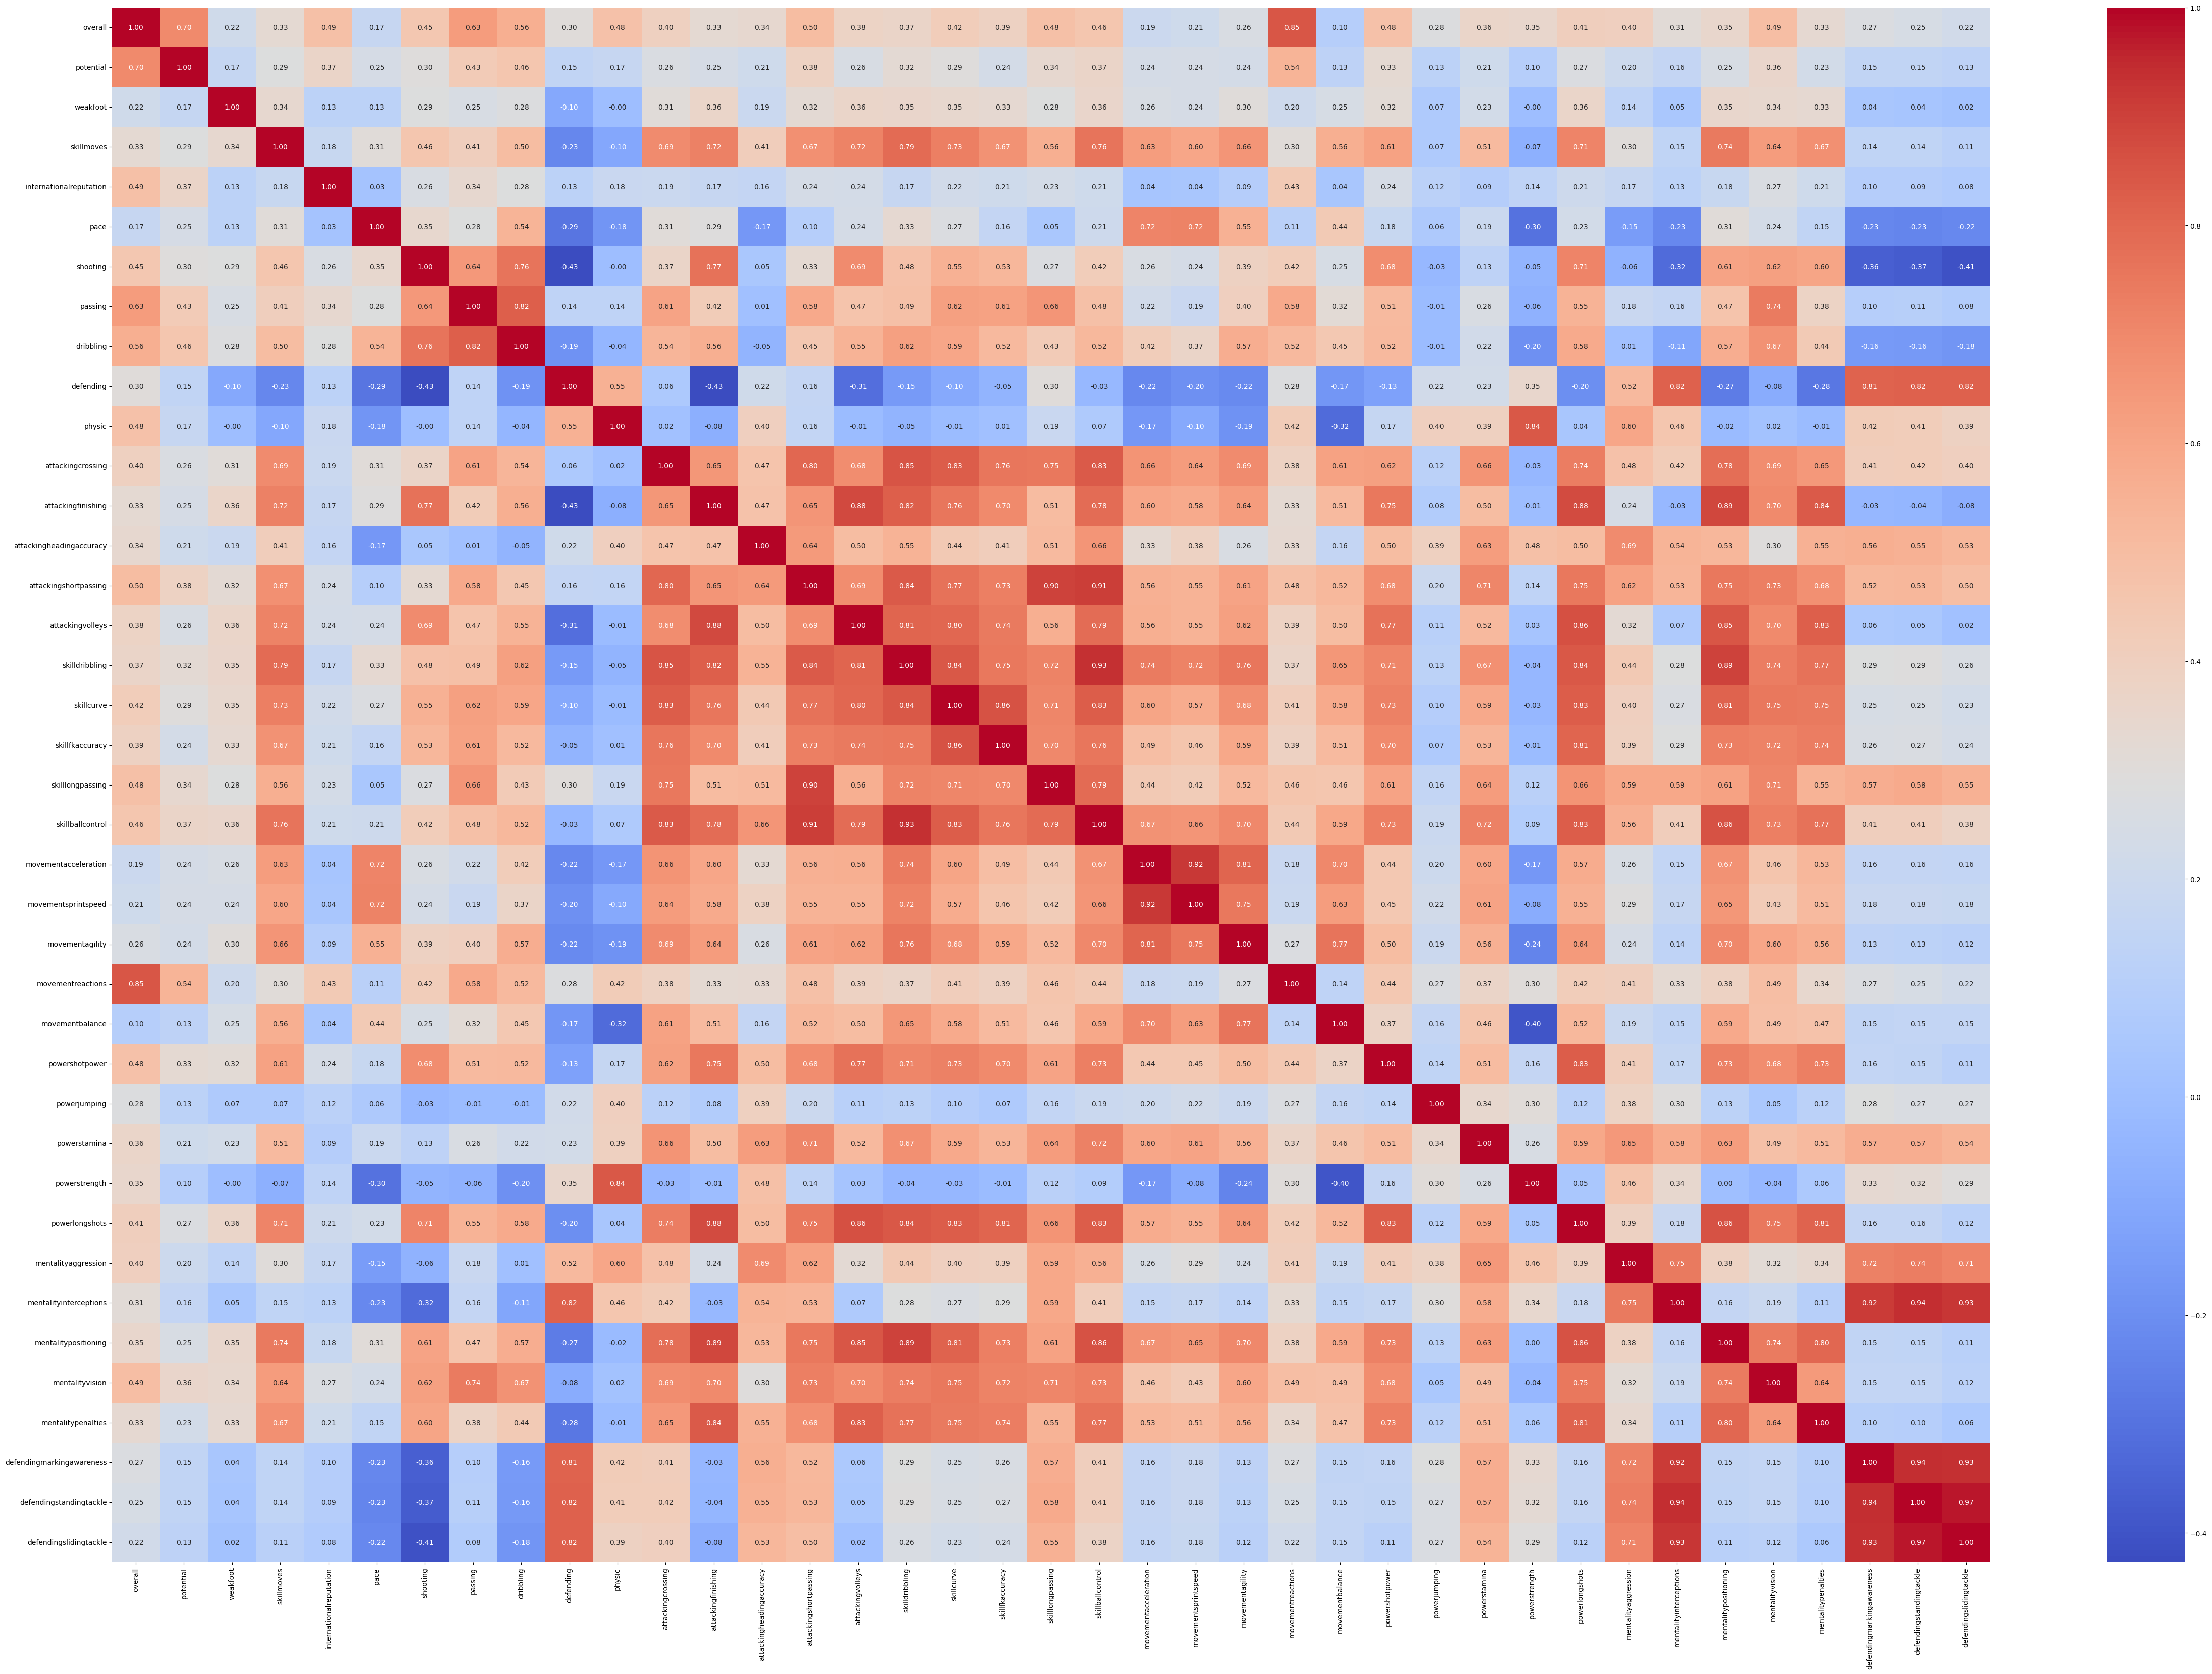

In [9]:
players_22_cleaned, players_22_encoders = clean_data(players_22, useless_columns)

players_22_aligned, male_legacy_cleaned = align_features(players_22_cleaned, male_legacy_cleaned)

# Check correlations for male_legacy_cleaned
correlation_matrix = male_legacy_cleaned.corr()
plt.figure(figsize=(60, 40))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

### Model Training

In [10]:
# Selecting features with high correlation with 'overall_rating'
cor_target = abs(correlation_matrix["overall"])
relevant_features = cor_target[cor_target > 0.5].index.tolist()
print("Relevant features:", relevant_features)
relevant_features


# Prepare data
X = male_legacy_cleaned[relevant_features].drop(columns=['overall'])
y = male_legacy_cleaned['overall']

# Split data into training and validation sets
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=42)


Relevant features: ['overall', 'potential', 'passing', 'dribbling', 'movementreactions']


In [11]:
# Train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=100, random_state=42, early_stopping_rounds=10
    ),
}


### Model Performance & Optimization



In [12]:
# Fine-tuning and Optimization
#Linear regression

param_grid_lr = {
    'fit_intercept': [True,False]
}
lr = LinearRegression()

grid_search_lr = GridSearchCV(estimator = lr, param_grid=param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_lr.fit(Xtrain, ytrain)
pkl.dump(grid_search_lr, open(grid_search_lr.__class__.__name__+'_lr'+ '.pkl', 'wb'))

best_lr_model = grid_search_lr.best_estimator_
best_lr_params = grid_search_lr.best_params_
print("Best parameters for Linear Regression: ", best_lr_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for Linear Regression:  {'fit_intercept': False}


In [13]:
#RandomForestRegressor
# Define parameter distributions for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 150),      # Random integer range for n_estimators
    'max_features': ['sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}
# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Perform randomized search
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit randomized search on training data
random_search_rf.fit(Xtrain, ytrain)

pkl.dump(random_search_rf, open( 'RandomizedSearchCV_rf.pkl', 'wb'))
#Get the best model and parameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_rf_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Random Forest:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 108}


In [14]:

param_dist_xgb = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 7),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'early_stopping_rounds': [10, 20, 50]

}
# Initialize the model
xgb = XGBRegressor(
     random_state=42,
     eval_metric='rmse'
 )
eval_set = [(Xval, yval)]

# Perform randomized search
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)
random_search_xgb.fit(Xtrain, ytrain, eval_set=eval_set)

pkl.dump(random_search_xgb, open('RandomizedSearchCV_xgb.pkl', 'wb'))
# Get the best model and parameters
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_params = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_xgb_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:0.94300
[1]	validation_0-rmse:0.87759
[2]	validation_0-rmse:0.83194
[3]	validation_0-rmse:0.77422
[4]	validation_0-rmse:0.72629
[5]	validation_0-rmse:0.68062
[6]	validation_0-rmse:0.64013
[7]	validation_0-rmse:0.60443
[8]	validation_0-rmse:0.57548
[9]	validation_0-rmse:0.54776
[10]	validation_0-rmse:0.52544
[11]	validation_0-rmse:0.50635
[12]	validation_0-rmse:0.48968
[13]	validation_0-rmse:0.47530
[14]	validation_0-rmse:0.46063
[15]	validation_0-rmse:0.44804
[16]	validation_0-rmse:0.43894
[17]	validation_0-rmse:0.42960
[18]	validation_0-rmse:0.42147
[19]	validation_0-rmse:0.41464
[20]	validation_0-rmse:0.40968
[21]	validation_0-rmse:0.40498
[22]	validation_0-rmse:0.40128
[23]	validation_0-rmse:0.39811
[24]	validation_0-rmse:0.39446
[25]	validation_0-rmse:0.39180
[26]	validation_0-rmse:0.38915
[27]	validation_0-rmse:0.38709
[28]	validation_0-rmse:0.38513
[29]	validation_0-rmse:0.38371
[30]	validation_0-

### Testing on New Data

In [30]:

# Prepare the test data
Xtest = players_22_aligned[relevant_features].drop(columns=['overall'])
ytest = players_22_aligned['overall']

# Evaluate the models
# Evaluate Linear Regression
y_pred_lr = best_lr_model.predict(Xtest)
mse_lr = mean_squared_error(ytest, y_pred_lr)
mae_lr = mean_absolute_error(ytest, y_pred_lr)
print(f"Linear Regression - MSE and MAE: {round(mse_lr, 2)} , {round(mae_lr, 2)}")

# Evaluate Random Forest
y_pred_rf = best_rf_model.predict(Xtest)
mse_rf = mean_squared_error(ytest, y_pred_rf)
mae_rf = mean_absolute_error(ytest, y_pred_rf)
print(f"Random Forest - MSE and MAE: {round(mse_rf, 2)}, {round(mae_rf, 2)}")

# Evaluate XGBoost
y_pred_xgb = best_xgb_model.predict(Xtest)
mse_xgb = mean_squared_error(ytest, y_pred_xgb)
mae_xgb = mean_absolute_error(ytest, y_pred_xgb)
print(f"XGBoost - MSE and MAE: {round(mse_xgb, 2)}, {round(mae_xgb, 2)}")

mae_values = {
    "Linear Regression": mae_lr,
    "Random Forest": mae_rf,
    "XGBoost": mae_xgb
}



Linear Regression - MSE and MAE: 0.17 , 0.25
Random Forest - MSE and MAE: 0.12, 0.25
XGBoost - MSE and MAE: 0.14, 0.29


In [53]:
mse_values = {
    "Linear Regression": mse_lr,
    "Random Forest": mse_rf,
    "XGBoost": mse_xgb
}

best_mse = float("inf")
best_model_name = ""
for model, mse in mse_values.items():
    if mse < best_mse:
        best_mse = round(mse, 2)
        best_model_name = model.replace(" - MSE", '')

print(f"The best model is {best_model_name}, with a mean squared error of {best_mse}")

The best model is Random Forest, with a mean squared error of 0.12


##Confidence level


In [55]:
# Save the best model

if best_model_name == "Linear Regression":
    best_model = best_lr_model
    with open('best_model.pkl', 'wb') as file:
        pkl.dump(best_lr_model, file)
elif best_model_name == "Random Forest":
    best_model = best_rf_model
    with open('best_model.pkl', 'wb') as file:
        pkl.dump(best_rf_model, file)
elif best_model_name == "XGBoost":
    best_model = best_xgb_model
    with open('best_model.pkl', 'wb') as file:
        pkl.dump(best_xgb_model, file)

In [56]:
# Final evaluation on the test set
y_pred = best_model.predict(Xtest)
final_mse = mean_squared_error(ytest, y_pred)
final_mae = mean_absolute_error(ytest, y_pred)
print(f"\nFinal Evaluation ({best_model_name}) on Test Set - MSE: {final_mse:.2f}, MAE: {final_mae:.2f}")


#Calculate and print the 95% confidence intervals for linear regression
if best_model_name == 'Linear Regression':
  from scipy.stats import t

  # Get predictions for a set of input features
  y_pred = best_model.predict(Xtest)

  # Calculate the standard error of the estimate (SEE)
  n = len(Xtest)  # Number of observations
  p = Xtest.shape[1]  # Number of predictors
  mse = mean_squared_error(ytest, y_pred)  # Mean squared error
  SEE = np.sqrt(mse * (1 + 1/n + ((Xtest - Xtest.mean())**2).sum(axis=0) / ((n-1) * Xtest.var(axis=0))))
  alpha = 0.05 # 95% confidence interval
  t_crit = t.ppf(1 - alpha/2, df=n-p-1)

  # Calculate confidence intervals
  lower_ci = y_pred - t_crit * SEE
  upper_ci = y_pred + t_crit * SEE

  # Print confidence intervals (example)
  for i in range(5):  # Print first 5 predictions with intervals
      print(f"Prediction {i+1}: {y_pred[i]:.2f} (95% CI: {lower_ci[i]:.2f} - {upper_ci[i]:.2f})")





Final Evaluation (Random Forest) on Test Set - MSE: 0.12, MAE: 0.25


In [57]:
if best_model_name == 'Random Forest':
    # Use cross_val_predict to get out-of-bag predictions for intervals
    y_pred = cross_val_predict(best_model, X, y, cv=5)

    # Calculate standard deviation of predictions as a proxy for confidence
    std_dev = np.std(y_pred)

    # Calculate 95% prediction interval
    y_lower = y_pred - 1.96 * std_dev
    y_upper = y_pred + 1.96 * std_dev

    # Print prediction intervals
    for i in range(5):  # Assuming you want to print the first 5 predictions as an example
        print(f"Prediction {i+1}: {y_pred[i]:.2f} (95% PI: {y_lower[i]:.2f} - {y_upper[i]:.2f})")

Prediction 1: 3.84 (95% PI: 2.02 - 5.66)
Prediction 2: 3.42 (95% PI: 1.59 - 5.24)
Prediction 3: 3.31 (95% PI: 1.49 - 5.13)
Prediction 4: 2.98 (95% PI: 1.16 - 4.80)
Prediction 5: 3.31 (95% PI: 1.49 - 5.14)


In [43]:
# Calculate and print the 95% prediction interval for XGBoost
if best_model_name == "XGBoost":
  # Use cross_val_predict to get out-of-bag predictions for intervals
  y_pred = cross_val_predict(best_model, X, y, cv=5)

  # Calculate standard deviation of predictions as a proxy for confidence
  std_dev = np.std(y_pred)

  #  95% prediction interval
  y_lower = y_pred - 1.96 * std_dev
  y_upper = y_pred + 1.96 * std_dev

  # Print prediction intervals
  for i in range(5):
    print(f"Prediction {i+1}: {y_pred[i]:.2f} (95% PI: {y_lower[i]:.2f} - {y_upper[i]:.2f})")

In [54]:
print(f"The best model is {best_model_name}, with a mean squared error of {best_mse}")

The best model is Random Forest, with a mean squared error of 0.12
